# Python Script Generation

-----

### ANLY-580: Natural Language Processing

This notebook contains the code required to perform Python script generation as a part of Georgetown University's ANLY-580 Final Project.

<br>

Authors:
* Eduardo Armenta (ea795@georgetown.edu)
* Landon Carpenter (lc1276@georgetown.edu)
* Matthew Moriarty (mdm341@georgetown.edu)

<br>

In this notebook, we will use a Generative Pre-Trained Transformer (GPT) model in order to generate Python scripts from given English prompts. An example of this is as follows:

```
## Input - English Prompt
"write a python function that computes the maximum of three integers"

## Output - Python Script
def (num1, num2, num3):
  max = num1
  if num2 > max:
    max = num2
  if num3 > max:
    max = num3
  return max
```

In order to accomplish this task, we will heavily utilize `Hugging Face` and `PyTorch`. These resources provide libraries such as `transformers` and `torch` that will be very useful to us in accomplishing our task.

We will also utilize Google Colab in order to obtain the computations resources required for training our model. Here, we can use GPUs - rather than CPUs - to perform the heavy computational tasks required by our model. As such, it is important to find the `Runtime` tab above, navigate to `Change runtime type`, and select the `GPU` hardware accelerator.

# Setup

In this section, we ensure that our Google Colab environment is equipped with the necessary resources before proceeding with our task.

## Installing Necessary Libraries

Before we begin building our models and completing our task, we must ensure that we have the necessary libraries installed. Here, we will install the following:

* `transformers`: this library allows us to access our GPT2 model, tokenizer, and other resources.

In [ ]:
# install transformers
!pip install transformers

Google Colab already has the other libraries that we need installed, such as `torch`, `pandas`, and `numpy`, so we can proceed with importing these libraries into our Python environment.

## Importing Necessary Libraries

With the required libraries installed on Google Colab, we can import them into our Python environment.

In [2]:
# perform necessary imports

# data manipulation libraries
import pandas as pd
import numpy as np

# huggingface transformer libraries
from transformers import GPT2Tokenizer, GPT2LMHeadModel # , do we need these? GPT2Model, GPT2Config, AutoModelWithLMHead
from transformers import get_linear_schedule_with_warmup # AdamW

# pytorch libraries
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split#, RandomSampler, SequentialSampler

# progress bar for model training
from tqdm.auto import tqdm

### additional imports, not sure if we need these either?
# import re, os, sys, time, datetime, nltk, random

### we aren't plotting anything are we?
# import seaborn as sns
# import matplotlib.pyplot as plt

# from torch.utils.data import Dataset, DataLoader, random_split # , do we need these? RandomSampler, SequentialSampler
# torch.manual_seed(42)

## Uploading the Data

In order to access the data that we'd like to use for our Python script generation task, we must upload it to Google Colab in a location that is accessible to us. We will upload our data, contained in the `pythonTextData.txt` file, to the `sample_data/` directory provided by Google Colab.

# Prepare the Data

In this section, we prepare our data for use in our Python script generation task.

## Read in the Data

We first must read in the data. As specified in the previous section, we will be reading this data from the following location: `sample_data/pythonTextData.txt`.

In [3]:
# read in the data using a try-catch block for error-handling
try:  
  with open("sample_data/pythonTextData.txt", "r", encoding = "utf8") as file:
    # read in the file as a list of lines
    lines = file.readlines()
    # report success and number of lines read in
    print('The data has been read in successfully.')
    print('The data contains', len(lines), 'lines.')
except:
  # report failure by raising exception
  raise Exception('There was a problem reading in the data.')

The data has been read in successfully.
The data contains 42745 lines.


## Preprocess the Data

We have read in our data, but we need to extract the information we need from it. The first several lines of the data look like the following:

```
# write a python program to add two numbers
num1 = 1.5
num2 = 6.3
sum = num1 + num2
print(f'Sum: {sum}')


# write a python function to add two user provided numbers and return the sum
def add_two_numbers(num1, num2):
    sum = num1 + num2
    return sum
```

As we can see, the data is formatted in such a way that each prompt is on a line of its own and starts with a `#` character, just like a Python in-line comment. Each prompt is then followed by one or more lines that define the Python code that completes the task that the prompt raises. Finally, these code blocks are followed by two empty lines before the next prompt appears. We can utilize this structure in order to extract each prompt and its corresponding Python code block.

In [4]:
# collect all indices of lines with '#'
src_indexes = [i for i, line in enumerate(lines) if line.startswith('#')]
# extract all those lines for use in the source column
src = [lines[i].lower() for i in src_indexes]

# collect all the targets by extracting the lines between the indices of the sources
tgt = [''.join(lines[src_indexes[i]+1:src_indexes[i+1]]).lower() for i, value in enumerate(src_indexes[:-1])]
# retrieve the last one as it is not captured by the line above
tgt.append(''.join(lines[src_indexes[-1]+1:]))

# assert that we collected the same number of sources and targets\n",
assert len(src) == len(tgt), 'The number of sources (prompts) collected does not equal the number of targets (code blocks) collected.'

# place source-target pairs into a data frame
python_df = pd.DataFrame({'src':src, 'tgt':tgt})

# create a new column that is the concatenation of each source-target pair
python_df['txt'] = python_df['src'] + ' | ' + python_df['tgt']

It's important to visually observe what we have done in our preprocessing steps, so let's take a look at the first few rows of the data frame.

In [5]:
# display the first five rows of the data frame
python_df.head(5)

,src,tgt,txt
0,# write a python program to add two numbers \n,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...,# write a python program to add two numbers \n...
1,# write a python function to add two user prov...,"def add_two_numbers(num1, num2):\n sum = nu...",# write a python function to add two user prov...
2,# write a program to find and print the larges...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...,# write a program to find and print the larges...
3,# write a program to find and print the smalle...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...,# write a program to find and print the smalle...
4,# write a python function to merge two given l...,"def merge_lists(l1, l2):\n return l1 + l2\n...",# write a python function to merge two given l...


# Construct the Model

In this section, we will prepare the rest of our resources for our Python script generation task. Here, we will create our model using the `GPT2Tokenizer` and the `GPT2LMHeadModel` from the `transformers` library, create a simple `Dataset` class specific to our task, and utilize the `DataLoader` from the `torch.utils` library in order to provide our data to our model.

## Define Hyperparameters

We can first define some hyperparameters that we will use throughout this section. These include:

* `bsize`: the batch size to use when batching data
* `epochs`: the number of epochs to use in training
* `lr_init`: the initial rate by which the model learns
* `warmup_steps`: the number of steps to take during training before utilizing the initialized learning rate

Note that we will use a very small batch size (`bsize = 4`) in order to preserve memory on Google Colab's GPU.


In [6]:
# define hyperparameters
bsize = 2
epochs = 5
lr_init = 1e-5
warmup_steps = 100

## Build the Tokenizer

We will retrieve our tokenizer using the pretrained `distilgpt2` option provided by Hugging Face.

In [7]:
# initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<SOS>', eos_token='<EOS>', pad_token='<PAD>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Build the Dataset

We will use `torch.utils.data`'s `Dataset` and `DataLoader` features in order to construct our dataset in such a way that is compatible with our model (<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">PyTorch: Datasets & DataLoaders</a>).

First, we will create a class `Python_Dataset` using `torch.utils.data`'s `Dataset`.

In [8]:
# 'Python_Dataset' class for our python text data
class Python_Dataset(Dataset):

  # we need an __init__ function
  def __init__(self, input_txt, input_tokenizer):# do we need these?, gpt2_type="gpt2", max_length=768):

    # store the incoming tokenizer as an attribute of the instance
    self.tokenizer = input_tokenizer
    # create attributes to store input IDs and attention masks
    self.input_ids_list = []; self.attention_mask_list = []

    # iterate through each source-target pair
    for txt in input_txt:
      # encode the text using special tokens defined above
      encodings_dict = input_tokenizer('<SOS>'+ txt + '<EOS>', truncation = True, padding = "max_length") # , max_length = max_length)
      # store the encoded input IDs and attention mask as tensors
      input_ids = torch.tensor(encodings_dict['input_ids'])
      attention_mask = torch.tensor(encodings_dict['attention_mask'])
      # append the input IDs and attention mask to the class attribute lists
      self.input_ids_list.append(input_ids)
      self.attention_mask_list.append(attention_mask)

  # we need a __len__ function 
  def __len__(self):
    # return the number of lists of input IDs gathered (should match number of texts)
    return len(self.input_ids_list)

  # we need a __getitem__ function
  def __getitem__(self, idx):
    # return a tuple of the input IDs and attention mask for the current item
    return self.input_ids_list[idx], self.attention_mask_list[idx] 

Next, we will create an instance of the `Python_Dataset` class using the class constructor and the data frame that we stored our data in, `python_df`.

In [9]:
# create instance of Python_Dataset class
python_dataset = Python_Dataset(python_df['txt'], tokenizer)#, max_length=768)

We can then split our data into training and testing sets, using a random 80%-20% split. We can continue to utilize `torch.utils.data` here and use the `random_split` function for this. We should also check our result to ensure that the split is made correctly. We can print the length of each resulting partition in order to ensure this. With 4,958 source-target pairs, we can expect to see approximately **3,966** observations in our training dataset and the remaining **992** in our testing dataset.

In [10]:
# perform an 80/20 split of the data for training/testing
# train_len = int(0.80 * len(python_dataset))
# test_len = len(python_dataset) - train_len
# train_data, test_data = random_split(python_dataset, [train_len, test_len])

# report the number of observations for both training and testing
print('Number of training observations:', len(python_dataset)) ###
# print('Number of testing observations:', len(test_data))

Number of training observations: 4958


Finally, we can wrap an *iterable* around our dataset using `torch.utils.data`'s `DataLoader`. According to documentation for this feature, wrapping an iterable around the dataset allows the observations within the dataset to be more easily accessed.

We can once again ensure that our data has been loaded properly by observing the lengths of our DataLoader objects. Using a batch size of 16, we can expect the training DataLoader to have ceil($\frac{3966}{16}$)= **248** batches. Similarly, we can expect the testing DataLoader to have ceil($\frac{992}{16}$)= **62** batches.

In [11]:
# create the data loader for both training and testing
# train_batches = DataLoader(train_data, batch_size = bsize)#, # sampler = RandomSampler(train_dataset),)
# test_batches = DataLoader(test_data, batch_size = bsize)#, # sampler = SequentialSampler(val_dataset),)

all_batches = DataLoader(python_dataset, batch_size = bsize)

# report the number of loaded batches for both training and testing
print('Number of training batches:', len(all_batches))
# print('Number of testing batches:', len(test_batches))

Number of training batches: 2479


## Build the Model

We will use `transformers`' `GPT2LMHeadModel` here in order to retrieve our model. Using the `distilgpt2` option as we used with the tokenizer, we can retrieve a smaller, more manageable version of GPT2.

In [12]:
# initialize the model using distilgpt2
model = GPT2LMHeadModel.from_pretrained("gpt2")#, config=configuration)

model.resize_token_embeddings(len(tokenizer));

Since our model will require strong computational resources, we could place the model directly on Google Colab's GPU, but we opt for a safer way of doing so. Below, we only place the model on the GPU if it is available.

In [13]:
# send the model to the available device
if torch.cuda.is_available():
  # if available, use GPU
  device = torch.device('cuda:0')
else:
  # otherwise, use CPU
  device = torch.device('cpu')

# push the model to the selected device
model.to(device);

# report the device that the model was pushed to
print('The model has been pushed to device:', device)

The model has been pushed to device: cuda:0


We can also initialize our optimizer and create a scheduled learning rate. These components will allow our model to learn in a more constructive way, rather than a more erratic one.

In [14]:
# initialize optimizer
optimizer = AdamW(model.parameters(), lr = lr_init)

# initialize a scheduled learning rate
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps = warmup_steps, 
    num_training_steps = len(all_batches)) # train_batches

# Train the Model

In this section, we train our model using all the features that we have organized. We define a function, `runner`, to execute the training process and call the function using our training data.

In [15]:
def runner(batches):

  # prepare for training
  model.train()

  # train the model over the number of specified epochs
  for epoch in range(epochs):

    # start a progress bar, which will help for observing runtime
    print('Training: Epoch', epoch + 1)
    progress_bar = tqdm(range(len(batches)))

    # iterate through all batches
    for batch in batches:

      # extract the input IDs (position 0)
      input_ids = batch[0].to(device)
      labels = batch[0].to(device)
      # extract the attention masks (position 1)
      attention_masks = batch[1].to(device)       

      # retrieve the outputs of the model
      outputs = model(input_ids,
                      labels = labels, 
                      attention_mask = attention_masks,
                        # token_type_ids=None
                     ) 

      # compute loss and backpropogate
      loss = outputs.loss
      loss.backward()
      # advance the optimizer and learning rates
      optimizer.step()
      lr.step()
      # zero out gradients so they won't affect the next batch
      optimizer.zero_grad()

      # update the progress bar
      progress_bar.update(1)

In [ ]:
# train the model using the function above
runner(all_batches)

Training: Epoch 1


  0%|          | 0/2479 [00:00<?, ?it/s]

In [41]:
### MATT ADAPTATION

# total_t0 = time.time()

training_stats = []

# model = model.to(device)

# start a progress bar, which will help for observing runtime
progress_bar = tqdm(range(len(train_batches)*epochs))

# prepare for training
model.train()

# for epoch_i in range(0, epochs):
for epoch in range(epochs):

    # ========================================
    #               Training
    # ========================================

    # print("")
    # print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    # print('Training...')

    # t0 = time.time()

    total_train_loss = 0

    model.train()

    # for step, batch in enumerate(train_dataloader):
    for batch in train_batches:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)       

        outputs = model(  b_input_ids,
                          labels = b_labels, 
                          attention_mask = b_masks,
                          token_type_ids = None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        # if step % sample_every == 0 and not step == 0:

        #     elapsed = format_time(time.time() - t0)
        #     print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

        #     model.eval()

        #     sample_outputs = model.generate(
        #                             bos_token_id=random.randint(1,30000),
        #                             do_sample=True,   
        #                             top_k=50, 
        #                             max_length = 200,
        #                             top_p=0.95, 
        #                             num_return_sequences=1
        #                         )
        #     for i, sample_output in enumerate(sample_outputs):
        #           print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
        #     model.train()

        loss.backward()

        optimizer.step()

        lr.step()

        model.zero_grad() 

        # update the progress bar
        progress_bar.update(1)

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_batches)       
    
    # Measure how long this epoch took.
    # training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================


##########


#     print("")
#     print("Running Validation...")

#     t0 = time.time()

#     model.eval()

#     total_eval_loss = 0
#     nb_eval_steps = 0

#     # Evaluate data for one epoch
#     for batch in validation_dataloader:
        
#         b_input_ids = batch[0].to(device)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)
        
#         with torch.no_grad():        

#             outputs  = model(b_input_ids, 
# #                            token_type_ids=None, 
#                              attention_mask = b_masks,
#                             labels=b_labels)
          
#             loss = outputs[0]  
            
#         batch_loss = loss.item()
#         total_eval_loss += batch_loss        

#     avg_val_loss = total_eval_loss / len(validation_dataloader)
    
#     validation_time = format_time(time.time() - t0)    

#     print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#     print("  Validation took: {:}".format(validation_time))

#     # Record all statistics from this epoch.
#     training_stats.append(
#         {
#             'epoch': epoch_i + 1,
#             'Training Loss': avg_train_loss,
#             'Valid. Loss': avg_val_loss,
#             'Training Time': training_time,
#             'Validation Time': validation_time
#         }
#     )


##########


print("")
print("Training complete!")
# print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/80 [00:00<?, ?it/s]


Training complete!


In [ ]:
### OLD VERSION

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,231. Loss: 0.30973324179649353.   Elapsed: 0:00:50.
0:  bipartisan,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,231. Loss: 0.16636155545711517.   Elapsed: 0:01:43.
0:  increasing# write a python function to extract name from string
 | 
print("input string: "))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,231. Loss: 0.253745973110199.   Elapsed: 0:02:33.
0: day# write a python program to print the total count
 | import count
def total_count ( count, values = [])
count = count * values
print(count, total_count, values)
print(count)



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,231. Loss: 0.13521066308021545.   Elapsed: 0:03:24.
0:  Hang# write a function that takes a dict.get a dictionary and returns the same value
 | def dict(dict1, dict2):
    return dict1
  def dict2(dict1, dict2):
     return dict1


def set_dict(dict1, dict2):
       return (dict2[1:] + dict1[2:])


def add(dict1):
       print(dict2.get(dict1, dict2))

     return (dict1.get(dict2, dict2) + dict2)

    else:
       print(dict1)


def add(dict2):
     return dict1

    return(dict2)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,231. Loss: 0.23476506769657135.   Elapsed: 0:04:16.
0:  foods# write a function to return whether a file is composed of multiple words
 | 
def   writea(file1, file2):
       return file1[0] + file2[1]





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,231. Loss: 0.32761454582214355.   Elapsed: 0:05:06.
0:  trail# write a function to return the maximum frequency of a given string by recursion
 | def get_maximum_fahrenheit_from_string(string):
   if not string:
    return "max_fahrenheit_ from string"
print("best" * {5}").format(string.length())
else:
   print("the highest {5}")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,231. Loss: 0.9197306632995605.   Elapsed: 0:05:57.
0: intend# write a python function to check if element is a palindrome
 | def palindrome(e:string):
    return e[::2]




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,231. Loss: 0.0569000281393528.   Elapsed: 0:06:48.
0:  surround# write a python program to find the area of a square root of the area of a cube with given area and cube height  
 |  def cal_area_square_radius(radius,height):  
      return (radius**3)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,231. Loss: 0.14406147599220276.   Elapsed: 0:07:38.
0:  reflex# write a function that will return the area of the area of a circle
 | def cal_areaarea(area, area_area):
   return (area * 1 ** 8)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,231. Loss: 0.19377556443214417.   Elapsed: 0:08:29.
0:  display# initializing python program
 | import time
n = time.days(len(tup(tup))
print("after initializing tuple list: ")
print ("initizing tuple list : "))
print (f'total tuple after initializing tuple list: ", str.upper())




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,231. Loss: 0.07458175718784332.   Elapsed: 0:09:19.
0:  pastor# write a python program which returns n as an even number
 | nums = 0
while nums >= 0:
   if nums >= 0:
       nums -= 1
    else:
       nums -= 1
print ("the nums of", nums, nums)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,231. Loss: 0.1981954127550125.   Elapsed: 0:10:10.
0:  illicit# please write a python program to sort a list
 | 
def sort_alist(list):
       if list:
                     return [list.filter(len(list)) for list in list)]

                                                                                                                                   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,231. Loss: 0.22336742281913757.   Elapsed: 0:11:01.
0:  Liberation# write a program to create string values by string
 | str1 = str1.decode('best')
print("the powerof", str1)
if not str1.decode('best')
print("the powerof", str1)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,231. Loss: 0.09697529673576355.   Elapsed: 0:11:51.
0:  Nam# write a python function to find the odd length in the length of a string and print it  
 |    
def odd_length(my_string):    
      
    return my_string + my_string     

temp = [ele for ele in my_string]  




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,231. Loss: 0.11951907724142075.   Elapsed: 0:12:41.
0: ION# write python code to calculate total weighted average of three sublist
 | 
def weighted_average(lists): 
    return total weighted average(lists[:3])
 
print("average weighted average of three sublists:")  

    return sum(weights(lists[:5:])
  
print(f'{sum(weights(lists[:5:])} is {sum(weights(lists[:5:])}')




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,231. Loss: 0.12280315160751343.   Elapsed: 0:13:31.
0:  glimpse# write a python function to print the first n unique list in a dictionary with unique dictionary value.
 | def unique_list_with_id_key():
     unique_list_with_id_value(dst, {id=st.get(id()))}, {id=lst.get(id()))}')

dst.__init__(id_key=unique_list_with_id_key(), names={names}')


dst.res.dst_items()




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,231. Loss: 0.16331501305103302.   Elapsed: 0:14:22.
0:  Laure# write a python function to calculate the lcm on a number
 | def calc_lcm(n):
     return 2x(n-1) + 2x(n-2)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,231. Loss: 0.04992960765957832.   Elapsed: 0:15:11.
0: ism# write a python function that takes a string and sorts it by the second letter
 | def reverse_sentence(s = 'u', 'i', 'j','s', 'u']
   return sorted(sorted(s.intersection(''))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,231. Loss: 0.2102832794189453.   Elapsed: 0:16:01.
0: oun# write a python function to return the product of an interval using all else
 | 
def productintervals(interval):
   if interval >= 1:
       greaterintervals(interval),
       greater(interval-1),
       greater(interval-1),
         greater(interval-1),
          greater(interval-1),
           greater(interval-1),
              greater(interval-1),
           greater(interval-1),
           greater(interval-1),
             


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,231. Loss: 0.09303796291351318.   Elapsed: 0:16:53.
0:  election# write a python program to remove the punctuations from a string
 | 

  
test_str = "hello world"
print("the original string is : " + str(test_str))
print("the remainder of test_str is : " + str(test_str))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,231. Loss: 0.1659221202135086.   Elapsed: 0:17:42.
0:  crazy# write python program to create a dictionary that has all the values of each pair, as a list.
 | dict1 = {1: 5, 7: 7, 8: 7, 9: 7}

dict2 = {6: 7, 7: 7, 8: 7}
print("dict1:{dict2)}")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,231. Loss: 0.14148211479187012.   Elapsed: 0:18:32.
0:  bench# write a program to remove spaces from a list and print the new list
 | l = []
for x in li:
   s = l[:-1]
    if x.islower():
       new_l = new_list
print("remove spaces from a list and print list: ", new_l)



  Average training loss: 0.26
  Training epoch took: 0:18:48

Running Validation...
  Validation Loss: 0.15
  Validation took: 0:00:39

======== Epoch 2 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,231. Loss: 0.05213026702404022.   Elapsed: 0:00:49.
0:  incorporated# write a python program to extract all words from a given file
 | from random import re

print(re.findall('r')[:5])





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,231. Loss: 0.12873883545398712.   Elapsed: 0:01:39.
0: Peter#32. python program to multiply two numbers and display it
 | num1 = 823
num2 = 834
num3 = 6
num4 = 1
sum = num1 + num2 + num3




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,231. Loss: 0.18198241293430328.   Elapsed: 0:02:29.
0: uring# write python code to replace odd element in dictionary with " ", to remove empty dictionaries
 | mydict = {'odd': 1, 2, 3, 4} 
 



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,231. Loss: 0.061430029571056366.   Elapsed: 0:03:18.
0:  reproductive# write a python program to print the number of odd elements in a list of integers and the sum of the odd elements. print the sum
 | li = [11, 2, 5, 3, 5]
odd_nosums = li[0]
print(odd_nosums)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,231. Loss: 0.06915110349655151.   Elapsed: 0:04:08.
0:  zone# write a python function to check if a number is prime or not
 | def check_prime(n):
   if n == 1:
      if n == 2:
         return n
	
	else:
          return n




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,231. Loss: 0.14304013550281525.   Elapsed: 0:04:58.
0:  commits# define a function which can generate a string where the first and last character is the first and last character is the last character. the function needs to print the first and last character
 | def print_last_char(string):
    if not isinstance(string):
        print("".join(set(string))
     else:
          print(" ".join(set(string)))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,231. Loss: 0.13509559631347656.   Elapsed: 0:05:48.
0:  irony# write a program to remove tuples whose length is less than given length from a list of tuples.
 | tuplex = [('a', 'b', 'c'), ('a', 'b', 'c'), ('a', 'c'), ('a', 'b'), ('b', 'c'), (a, 'b', 'c'), (b, 'c'), (a, 'c'), (a, 'c'), (b, 'c'), (c, 'a'), (b, 'c'), (a, 'b'), (b, 'c'), (a, 'a'), (b, 'c'), (b, 'c'), (a, 'b'), (a, 'c')]
print(x_to_be_sent)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,231. Loss: 0.11015886813402176.   Elapsed: 0:06:39.
0:  Sah# write a python function to calculate simple interest
 | def simple_interest(lst): 
    si = 12 
    for i in range(0, lst - 1): 
       si += (i * 10 + 1)/100 * si 
         for i in range(0, 10):  
           si += (i - 1)/100 - 1 
     return si  
    
     
          



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,231. Loss: 0.25705328583717346.   Elapsed: 0:07:30.
0:  Bryan# write a function that returns the sum of the roots of a quadratic equation ax**2 + bx + c = 0
 | def cal_roots(a:float,b:float,c:float):
    return 2*2+b+c*(a**2+b**2)/100
def roots_of_n_qad_eq(n):
    if (n == 0) and (n == 0): return none
    return roots_of_n_qad_eq(n-1,n+2)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,231. Loss: 0.08756963163614273.   Elapsed: 0:08:21.
0:  spirits# write a python program to print the number of zeros in a list
 | def zeros(l1, l2):
    print(l1)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,231. Loss: 0.25399166345596313.   Elapsed: 0:09:11.
0:  sees# write a python program that sorts words in a sentence and prints the words' end in a comma-separated sequence
 | words = sentence.split() 
print(word.lower() - 1)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,231. Loss: 0.04898485541343689.   Elapsed: 0:10:00.
0:  hungry# write a function to count number of spaces in a string
 | 
def count_spaces(str1, str2):
    if len(str1) % 2 == 0:
        count += 1
   else:
          count += 1

   def count_spaces(str1, str2):
          if str1[0] <= ''.join(str2) and str1[1] <=''.join(str1) and str2[2] <=''.join(str2) and str1[2] <=''.join(str2) and str2[2] <=''.join(str1) and str2[2] <=''.join(str2) and str1[2] <=''.join(str2) and str2[


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,231. Loss: 0.05550263822078705.   Elapsed: 0:10:51.
0:  PT# write a python program to check if a tuple is symmetrical and print it if symmetry is valid
 | 
def symmetry_check(tup, tup):
     from bisect import bisect_left   
    yy = bisect_left(tup)  
    for i in range(x):  
        if (tup[tup[i] > tup[0] + 1]): 
             yy.update(i) 
     return yy




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,231. Loss: 0.08088714629411697.   Elapsed: 0:11:42.
0: ü# printing result 
 | print("incremented elements : " + str(res))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,231. Loss: 0.13483095169067383.   Elapsed: 0:12:32.
0: ruce# check if string is camelcase using try catch
 | word = '''this assignment assignment assignment is of 900 marks. marks.total marks.
 | ctr = (word, ctr)
if ctr.isupper() and ctr.find('a', 'c'),word.lower() or ctr.find('a', 'c') or ctr.find('a', 'c') or ctr.find('a'):
    ctr.update({1:1:1, 2:3, 3:4}')
else:
   ctr.replace('a', 'a', 'c')
   return ctr.replace('a', 'c', 'c')
  



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,231. Loss: 0.20598001778125763.   Elapsed: 0:13:22.
0:  derivatives# write a python program to remove punctuations from an input string and print it
 | punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
for n in punctuations:
   print(n)

i=0
while i<=0:
   i+=1
   n+=1
while i<=n:
    print(i)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,231. Loss: 0.09815408289432526.   Elapsed: 0:14:13.
0: # write a python function to check a given input strings is unique from a given string  
 |   
def countlist_unique(sentence):    
     count = 0
   
    return len(list(int(list(str(count)))))                                                                                                                                   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,231. Loss: 0.1071963757276535.   Elapsed: 0:15:04.
0:  remembering#write a python function that counts the number of spaces in a string
 | def count_space(str1):
    return str1.count(''.join(' '))


print("the number of spaces in a string are: ", count_space(str1))





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,231. Loss: 0.26972097158432007.   Elapsed: 0:15:54.
0:  Sources# write a program to calculate and print the length of a dict, whose keys are numbers from 1 to 9 (both included).
 | import dict
dict = dict()
dict_length = dict()
print("dict length : :                                                                                                                                                      


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,231. Loss: 0.25765496492385864.   Elapsed: 0:16:45.
0: ems# write a python program to check a string is palindrome or not
 | 
test_str = "gfg is best"
  



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,231. Loss: 0.11270835250616074.   Elapsed: 0:17:35.
0: tz# write a python program to extract digits from tuple list of string and print it
 | 
test_list = [(1,3), (3,2), (3,3), (3,3)] 
print("original list : " + str(test_list)) 




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,231. Loss: 0.11840007454156876.   Elapsed: 0:18:25.
0: matic# write a python function to convert decimal to binary
 | def binary_to_dict(n):
    return f"constructed decimal number: {n}".format(n,n)



  Average training loss: 0.14
  Training epoch took: 0:18:40

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:00:39

======== Epoch 3 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,231. Loss: 0.03384293615818024.   Elapsed: 0:00:49.
0:  synd# 3x5 matrix
 | y = [[1,2,3],[4,5,6],[7,8]]
result = [[0 for col in range(len(mat):]) for col in range(len(mat[0])]
print(result)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,231. Loss: 0.13256137073040009.   Elapsed: 0:01:39.
0:  gam# write a python function to find whether a positive integer is negative, negative, zero or even
 | def check_negative_even(n, val):
    if n % 2 == 0:
         return 2 ** 1 
    else:
       print("positive integer")
    return -bool(n // 2 )




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,231. Loss: 0.060016799718141556.   Elapsed: 0:02:29.
0:  injury# write a program to check and print the number of spaces in a string provided by the user
 | 
def check_space(str1, str2):
     if str1[-1] == str2[1]:
         return str1[-1]
    else:
         return str1[-1]


str1 = "abc4234afde"

print(check_space(str2))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,231. Loss: 0.0880725160241127.   Elapsed: 0:03:20.
0: aza# write a program to multiply two matrix and print the result. 
 | 
def multiply_matrix(mat):
    # initialize result
    # initialize result
    # for each element in the matrix
    # initialize result
    result = [[0 for col in range(mat)] for col in range(mat)] 
    for each element in the matrix
     result.append((col in range(mat)]  
    return result 





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,231. Loss: 0.11069986969232559.   Elapsed: 0:04:10.
0:  membrane# write a python function to find sum of all odd numbers from 0 to 9 and other parameters should include the user provided real numbers and the given real numbers  
 | def sum_of_all_odd(n):
     sum_of_all_odd = 0
    for i in range(0, 11):
         sum_of_all_odd += i
    return sum_of_all_odd




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,231. Loss: 0.07291994988918304.   Elapsed: 0:05:00.
0: ijing# given a python list, remove all occurrence of the first element and revert
 | list1 = [5, 20, 30]
samplelist = [list1, samplelist for samplelist in samplelist]
print(samplelist)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,231. Loss: 0.07325958460569382.   Elapsed: 0:05:50.
0:  cast# write a python function to find time for a given angle.
 | def calcangle(hh, mm):
    hour_angle = abs(hour_angle - minute) + minute
    minute_angle = min(hour_angle, minute) + minute
    angle = abs(hour_angle - minute - minute) + minute
    angle = min(hour_angle, minute - minute) + minute
    angle = min(hour_angle, minute - minute) + minute
    angle = min(hour_angle, minute - minute) + minute
   angle = min(hour_angle, minute - minute) + minute
    angle = abs(hour_angle, minute - minute) + minute
    angle = min(hour_angle, minute - minute)) + minute
    angle = min(hour_angle, minute - minute


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,231. Loss: 0.0757737085223198.   Elapsed: 0:06:41.
0:  purch# write a program to accept text and print the words and the characters that will determine if the upper case letter exists in the first 4 characters of a string
 | word = input("upper case letters:")
if word == "upper case" or word == "upper case":
word = "upper case"
print(word)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,231. Loss: 0.06926725059747696.   Elapsed: 0:07:31.
0:  shoulders# convert decimal to binary
 | dec = 344
binaryval = 'decimal'
binaryval = 'binaryval[::-1]\w+'




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,231. Loss: 0.06641462445259094.   Elapsed: 0:08:21.
0:  built# initializing k 
 | k = 10
t = 9
t = 0
 
  



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,231. Loss: 0.11594859510660172.   Elapsed: 0:09:10.
0:  openly# write a program to swap variable
 | a, b = 10
a, b = 10
print(a, b)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,231. Loss: 0.25126662850379944.   Elapsed: 0:10:00.
0:  halted# write a python function to convert a dictionary value list to string and print the new list
 | def dict_to_string(d):
    test_list = [{'end program' : (end + 1),    'is' : (int(d.values())}, {'best' : (int(d.values())}]
    return list(test_list)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,231. Loss: 0.09477080404758453.   Elapsed: 0:10:50.
0:  Nik# write a python function to find the area of a rectangle.
 | 
def rectangle_area(width, height):
     return 2*(width+ height**2)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,231. Loss: 0.05494183674454689.   Elapsed: 0:11:40.
0:  tin# write a function to calculate area of a cylinder
 | def cal_area_cylinder(height, radius):
   pi=3.14
   return 2*pi*radius




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,231. Loss: 0.09957006573677063.   Elapsed: 0:12:30.
0:  clinical# printing original tuples 
 | print("the original tuple 1 : " + str(test_tup1)) 
      



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,231. Loss: 0.1481553167104721.   Elapsed: 0:13:19.
0: lections# write a python program to check a dictionary value is present in a dictionary and print it
 | 
def check_dict(input_dict):
     return list(input_dict.get(value)=={"a": 1, "b": 2, "c": 3},  
               {"d": 'a'}, 
                {"f": "f" }
  
   return true




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,231. Loss: 0.02850925922393799.   Elapsed: 0:14:10.
0: els# driver code in python
 | def driver(n):
    if n == 0:
        return 0
     else:
          return n + 1
		
		



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,231. Loss: 0.051676370203495026.   Elapsed: 0:15:00.
0: lab#write a python program to print the number of letters and digits of a given string
 | 
s=input("enter a string: ")
dig=dig(s.split(' '))

for i in s:
    if(i==dig):
       break

print(f'dig: {s}')





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,231. Loss: 0.08538360148668289.   Elapsed: 0:15:50.
0:  triple# write a python function to convert a list of dictionaries to lists and return the list of values
 | def convert_list_to_values(list_of_values):
   return list([1, 2, 1, 3, 3, 1, 4, 1, 2, 1]





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,231. Loss: 0.12654007971286774.   Elapsed: 0:16:40.
0: 220# write a python function to remove empty list from a list of lists using filter function.
 | 
def remove_emptylist(list_of_list_list:list_of_list_list):
    return filter(lambda ele: ele[::-1]) == filter(lambda ele: ele[::-1]) == filter(lambda ele: ele[::-1]) == filter(lambda ele: ele[::-1]) == filter(lambda ele: ele[::-1]) == list_of_list_list_list_list_list_list.




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,231. Loss: 0.03334340825676918.   Elapsed: 0:17:30.
0:  See# write a python program to implement binary search without recursion and print the key element if found
 | 
def binary_search(alist, key):
    """search key in alist. """
    if key in alist:
        return key
 
alist = [2, 3, 5, 6, 7, 8]

if not alist:
    print('[0-9-1-1]', end='')
else:
     print('[0-5-1]', end='')




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,231. Loss: 0.0835384801030159.   Elapsed: 0:18:21.
0: @@# write a python function to remove tuples of length k  
 | def remove_tuple_(test_list:list): 
    t = list(test_list.strip()): 
    return t 
   
    
    if len(test_list) == k : 
       return (test_list.strip().split(' ')) 
    
    t = list(test_list.strip().split(' ')) 
    return t  
     
   else: 
      raise valueerror('invalid input')



  Average training loss: 0.11
  Training epoch took: 0:18:38

Running Validation...
  Validation Loss: 0.12
  Validation took: 0:00:39

======== Epoch 4 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,231. Loss: 0.026105130091309547.   Elapsed: 0:00:49.
0:  host# write a python function to calculate lcm
 | def compute_lcm(x, y):
   if x > y:
      greater = x
   else:
      greater = y
   while(true):
      greater = greater/x
      while(true):
           if((greater % x == 0) and (greater % y == 0)):
             lcm = greater
           break
     greater += 1

    if((greater % x == 0) and (greater % y == 0)):
       print("move disk 1 from left to right", lcm)
   else:
   


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,231. Loss: 0.06244303286075592.   Elapsed: 0:01:41.
0: role# write a python program to find time for current date and time
 |   
current_date = datetime.strptime(current_date)
print(current_date)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,231. Loss: 0.15324485301971436.   Elapsed: 0:02:31.
0: iac# in[81]:
 | 




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,231. Loss: 0.09983811527490616.   Elapsed: 0:03:20.
0:  LD# write a python program to get all possible permutations of '1,2,3,4,5,6,7,8'
 | def permute_prob(n):
    permutations = []
    for i in range(n):
          permutations.append([])
    return [permutations]


print(perms)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,231. Loss: 0.06217159703373909.   Elapsed: 0:04:10.
0:  Listen# write a python program to sort dictionary by key-value summation and print the sorted dictionary
 | def sort_dict_by_key_value(d:dict, key:dict):
    key = lambda x:len(x)
    value = key.value()
d.sort_dict_by_key(d.dict, key.value()))





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,231. Loss: 0.22549283504486084.   Elapsed: 0:05:00.
0:  dy# write a program to generate fibonacci series
 | n = 100
a=[1,2,3]
fibonacci series = a*b
print(fibonacci series)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,231. Loss: 0.04656447097659111.   Elapsed: 0:05:50.
0:  Domestic# write a python function to convert temperature  from fahrenheit to kelvin  
 |   
 def fahrenheit_to_kelvin(f): 
    if(f%3==0) and (f%4==0): 
       return (f%4)/5 
    elif(f%3==0 and (f%4==0): 
       return (f%4)/5 
    elif(f%4==0 and (f%4==0): 
        return (f%4)/5 
    else: 
        return none




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,231. Loss: 0.05769640579819679.   Elapsed: 0:06:41.
0:  beneficiaries# write a python program to print sum of natural numbers upto n, where n is an argument
 | n = 3

print(n)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,231. Loss: 0.13832524418830872.   Elapsed: 0:07:31.
0:  Title# write a python function to check if given string has at least one letter and one number
 | 
def check(string): 
    l = string[ : 10] 
    sum = 0
     for i in range(0, len(l)): 
           sum += l[i] 
    return true 
print (check(string)) 




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,231. Loss: 0.05174819007515907.   Elapsed: 0:08:21.
0:  μ# write a python function for dice roll asking user for input to continue and randomly give an output.
 | 
import random


def dice():
    from random import randint
    randint = '11'
    import random

    import os

     return random.randint(random.randint(2,10),2,4))

def dice():
    import random

    pass

print("rolling the dice...")
for i in range(4):
    dices = []
    for j in range(6):
        sum = random.randint(random.randint(random.randint(2,5),2,7),2,4)
                 dices.append(i)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,231. Loss: 0.05750125274062157.   Elapsed: 0:09:12.
0:  selling# write a python function to find the uncommon words from two strings.
 | def uncommonwords(str1, str2):
	res_set = {}
	for word in str1.split():
	res_set.update(word)
	return res_set




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,231. Loss: 0.13776500523090363.   Elapsed: 0:10:02.
0:  migrant# write a python program to add two integers without using the '+' operator in a list.
 | 
a=[2,3,4]
b=2
a+b=b




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,231. Loss: 0.07170932739973068.   Elapsed: 0:10:52.
0: ively# write a python function to find the greatest common divisor (gcd) of two integers.
 | def recurgcd(a, b):
   if b == 0:
      return (a % b % a)
   else:
      return none




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,231. Loss: 0.07175075262784958.   Elapsed: 0:11:42.
0:  order# write a function to return the volume of a cuboid of length l, bredth b, height h
 | def cal_cuboid_volume(l,b,h):
    return l*b*b




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,231. Loss: 0.07811251282691956.   Elapsed: 0:12:32.
0:  VPN#write a python program to print binary search without recursion
 | 
def bin_search(alist):
    """search key in alist[start... end - 1]."""
    for j in range(1, len(alist)):
         alist[j], alist[start... end - 1] = alist[j], alist[j]
               index = j - 1
             for j in range(i+1):
                  if alist[j + 1] < alist[j]:
                                alist


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,231. Loss: 0.11945264786481857.   Elapsed: 0:13:23.
0:  explanation# given a sorted integer array without duplicates, return the summary of its ranges.
 | input_array = [0]*(1)**len(input_array)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,231. Loss: 0.04063468426465988.   Elapsed: 0:14:13.
0:  Bach# write a python program that asks user for input to make a simple equation
 | 
a = 1
b = float('inf'), float('inf')
a_diff = -b
b_diff = -a- b
if a_diff >= 0:
    print("enter a number:", end=" ")
else:
    print("in a positive range:", end=" ")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,231. Loss: 0.027624232694506645.   Elapsed: 0:15:03.
0:  folder# printing result  
 | print("incremented numeric strings : " + str(res))





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,231. Loss: 0.02472463622689247.   Elapsed: 0:15:53.
0:  building# write a python program to add an element to a list
 | 
list1 = [10, 20, 30, 40, 50]
list2 = list1 + list2 

print(list2)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,231. Loss: 0.05709148570895195.   Elapsed: 0:16:42.
0:  Babylon# write a python function that takes a number of lines as input and counts the number of each line
 | def count_lines(lines):
    return len(lines)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,231. Loss: 0.10731413215398788.   Elapsed: 0:17:32.
0: perial# write a program to convert binary to gray code
 | def binary_to_gray(n):
    """convert binary to gray codeword and return it."""
    if n == 0:
        return bin(n)[::-1] + (n >> 2) + n[::-1])
    else:
       return (convert(n)[::-1]) + n[::-1])




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,231. Loss: 0.053033217787742615.   Elapsed: 0:18:23.
0:  rents# write a function to calculate the average time taken to perform any transaction by  function fn averaging the total time taken for transaction over repetations
 | def time_it(fn, *args, repetitons= 1, **kwargs):
    import time
    total_time = time.perf_counter()
    if __name__ == "__main__":
         total_time = []
    for _ in range(repetitons):
         time.append(time.strftime('%y-%m-%d %h:%m:%s')
         total_time.append(_)
     else:
          total_time.append(time.strftime('%y-%m-%

  Average training loss: 0.08
  Training epoch took: 0:18:40

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:00:39

======== Epoch 5 / 5 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  2,231. Loss: 0.026908645406365395.   Elapsed: 0:00:49.
0:  Reg# write a python program to extract tuples of length 1 from a list of tuples. print the extracted tuples.    
 |    
test_list = [(4, 5, 9), (-3, 6, 10), (-3, 5, 3), (-3, 6), (4, 5, 7)] 
res = [(sub[1]: sub[1:]) for sub in test_list for key in test_list] 
  
print("the extracted tuples : " + str(res))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  2,231. Loss: 0.06987442821264267.   Elapsed: 0:01:40.
0: olas# write a python program to generate a list of all unique elements in a list
 | input = [1,2,3]
samplelist = []
for i in range(len(input)):
   for j in range(len(input)-i-1):
        if((i % j == 0) and (input[j]) == 0):
            samplelist.append(input[j])
print(samplelist)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  2,231. Loss: 0.027332797646522522.   Elapsed: 0:02:30.
0:  responses# write a python program to print the binary value of a decimal number
 | dec = 344

print("binary value of", dec, " is:")
print(binary(dec), " is:")





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  2,231. Loss: 0.11479006707668304.   Elapsed: 0:03:20.
0:  attendance# write a python program to print a string in binary
 | print("yesterday = ", yesterday.strftime('%y-%d %h:%m:%p')




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  2,231. Loss: 0.06297052651643753.   Elapsed: 0:04:10.
0:  rigid# write a python function that takes in a string and returns it in lowercase
 | def print_lower(s):
  return s.lower()





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  2,231. Loss: 0.07158723473548889.   Elapsed: 0:04:59.
0: gro# write a python program that adds elements of two lists
 | 
list1 = [1, 2, 3, 4]
list2 = [5, 4, 3, 2, 1]
sum_list = [a+b for a,b in zip(list1, list2)]
print(f"sum of two lists:{sum_list}")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  2,231. Loss: 0.08140068501234055.   Elapsed: 0:05:49.
0:  Gre# iterate through rows
 | for i in range(len(x)):
  # iterate through columns
   for j in range(len(x[0])):
      result[j][i] = x[i][j]

for r in result:
  print(r)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  2,231. Loss: 0.11563535034656525.   Elapsed: 0:06:40.
0: ura# generate  random number between 2 ranges
 | import random

lower, upper = 2,5
number = random.randint(lower, upper)
print("generating a random number between", number, "and", its cube)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  2,231. Loss: 0.047015152871608734.   Elapsed: 0:07:29.
0:  2020# write a function to return the lateral surface area of a cylinder
 | def cal_cylinder_lat_surf_area(height,radius):
    pi=3.14
    return 2*pi*radius*height




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  2,231. Loss: 0.07454726845026016.   Elapsed: 0:08:19.
0:  charging# write a python program to check if a number is a perfect number
 | 
def perfect_no_check(num):
    sum1 = 0
    for i in range(1,num + 1):
        sum1 = sum1 + i
    return sum1




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  2,231. Loss: 0.027883952483534813.   Elapsed: 0:09:09.
0:  Sar# write a python function to calculate the geometric sum of the squares of the first two hundred natural numbers, if the square of the first two hundred is an even number, divide it by a given mean and standard deviation
 | def geometric_sum(x, y):
    e = 0
    while x**2 and y**2< e:
        e += 1
        y += 1
    return e




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  2,231. Loss: 0.058623313903808594.   Elapsed: 0:09:59.
0:  Jas# write a python function to check if a triangle is valid for all angles
 | 
def all_validity(a, b):
    return all(a+b for a,b in (a+b+c))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  2,231. Loss: 0.018667297437787056.   Elapsed: 0:10:49.
0:  permit# write a python function to print the factorial of a number
 | def factorial(n):
    if n == 1:
         return n
    else:
         return n * factorial(n-1)

factorial(7)





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  2,231. Loss: 0.17547450959682465.   Elapsed: 0:11:39.
0:  Administrator# write a python program to remove common elements from tuple list
 | from collections import counter
l=[[1,2,3], [4,5,6], [7,8,9]]
t=tuple(l)
print(l)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  2,231. Loss: 0.059273749589920044.   Elapsed: 0:12:29.
0:  EVENTS# write a python program to check whether a number is positive, negative or zero
 | num = 175
if num > 0:
   print("positive number")
elif num == 0:
   print("zero")
else:
   print("negative number")





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  2,231. Loss: 0.05363699048757553.   Elapsed: 0:13:19.
0:  Mental# write a python function that accepts an integer as input and converts it into a string
 | def convertstring(n):
    n = int(n, 2)
    return ''.join(str(n))





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  2,231. Loss: 0.060534123331308365.   Elapsed: 0:14:09.
0: ids# write a python function that accepts a list of dictionaries and sorts it by a specified key
 | 
def sort_dict_list(dict_list, sort_key):
  dict_list.sort(key=lambda x: (-x[1]//k) + key[1])

print(sort_dict_list)




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  2,231. Loss: 0.051640406250953674.   Elapsed: 0:14:59.
0: ceans# write a program to randomly generate a list with 5 numbers, which are divisible by 5 and 7, between 1 and 1000 inclusive.
 | import random
print(random.sample([i for i in range(1,1001) if i%5==0 and i%7==0], 5))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  2,231. Loss: 0.06254614144563675.   Elapsed: 0:15:49.
0:  genetically# write a python program to extract words starting with vowel from a list of strings
 | 
s = ['a', 'e', 'i', 'o', 'u']
k = 2
res = [] 
vow = ['a', 'e', 'i', 'o', 'u']
for v in s: 
    if v not in vow: 
        res.append(v)

print("words starting with vowel : " + str(res))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  2,231. Loss: 0.05196220427751541.   Elapsed: 0:16:39.
0:  advice# write a python function that returns true if the sum of two provided numbers is even
 | def is_prod_even(num1, num2):
  sum = num1 + num2
  return not sum % 2





The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  2,231. Loss: 0.030109701678156853.   Elapsed: 0:17:29.
0:  incomplete# iterate through rows of x
 | for i in range(len(x)):
   # iterate through columns of y
   for j in range(len(y[0])):
       # iterate through rows of y
       for k in range(len(y)):
           result[i][j] += x[i][k] * y[k][j]
print(f"final result is{result}")




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  2,231. Loss: 0.02070428617298603.   Elapsed: 0:18:20.
0: comment# printing original dictionary 
 | print("the original dictionary is : " + str(test_dict)) 
s=[]
for sub in test_dict.items():
    s.append(str(sub.get))
print(s) 



  Average training loss: 0.05
  Training epoch took: 0:18:35

Running Validation...
  Validation Loss: 0.10
  Validation took: 0:00:39

Training complete!
Total training took 1:36:34 (h:mm:ss)


In [ ]:
model.save_pretrained('gpt2')

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.26,0.15,0:18:48,0:00:39
2,0.14,0.13,0:18:40,0:00:39
3,0.11,0.12,0:18:38,0:00:39
4,0.08,0.10,0:18:40,0:00:39
5,0.05,0.10,0:18:35,0:00:39


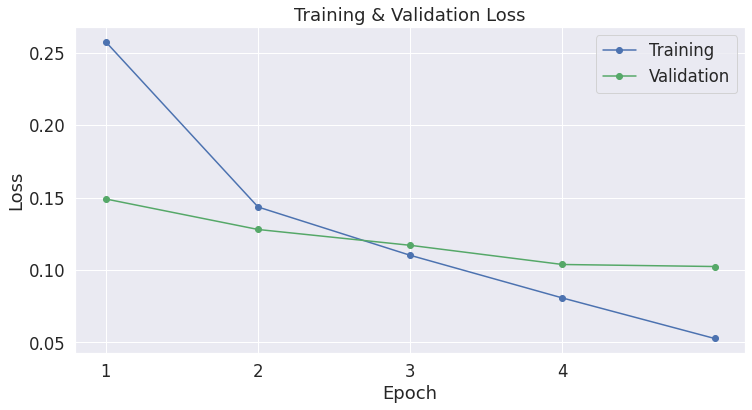

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")


plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [41]:
tokenizer.encode('<SOS>')

[50257]

In [51]:
prompt = "<SOS> # write a function that sums two integers | "

encoding = tokenizer(prompt)#, truncation = True, padding = "max_length")
input_ids = torch.tensor(encoding['input_ids']).to(device).unsqueeze(0)
attention_mask = torch.tensor(encoding['attention_mask']).to(device).unsqueeze(0)

bos = torch.tensor(tokenizer.encode('<SOS>')).to(device)
eos = torch.tensor(tokenizer.encode('<EOS>')).to(device)
pad = torch.tensor(tokenizer.encode('<PAD>')).to(device)

sample_outputs = model.generate(
                                input_ids = input_ids,
                                attention_mask = attention_mask, 
                                bos_token_id=bos,
                                eos_token_id=eos,
                                pad_token_id=pad,
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0:  # write a function that sums two integers |         
              
      
      
      
       
    
       
      
          
       
     
        
         
         
         
        
    
      
           
      
             
         
       
         
           
                        
             
        
          




In [31]:
model.eval()

prompt = "<SOS> # write a function that sorts a list | "

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=25, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,     2,  3551,   257,  2163,   326, 10524,   257,  1351,   930,
           220]], device='cuda:0')
0: # write a function that sorts a list | --------------------------- print a list of integers and integers
# print the list of integers and integers
# print the list of integers and integers
# print the list of integers and integers
# print the list of integers and integers
# print the list


